# Generating Images with Generative Adversarial Networks (GANs)

The purpose of the project is to test the ability of Generative Adversial Networks (GANs) in generating realistic-looking images. 

## Dataset

The dataset used will be FashionMNIST. It contains low resolution ($28 \times 28$) grey-scale images representing different kind of clothes. The dataset is available on keras and accessable in $\texttt{tf.keras.datasets.fashion\_mnist}$. Note that the pixel values for the images are initially in the interval $[0, 255]$. It is required to normalize them since all of the algorithm we will use require them to be in that format. To be fair, you will find the dataset already normalized, do not modify that part of the code.

## Metrics

Measuring the quality of newly generated images is a non-trivial task. Indeed, there is no label associated to each image, and thus it is impossible to measure the quality image-by-image. For that reason, common metrics uses statistical consideration on a generated dataset to test how well the network recovered the statistics of the original data. One of the most common is the Fréchet Inception Distance (FID). The idea of FID is that in a realistic-looking dataset of images, the statistics of the activation of the last hidden layer in a well-trained classificator should be similar to that of a dataset containing real images. Specifically, regarding FID, the Inception-v3 network is used as a classificator. A real dataset $\mathbb{D}_r$ and a generated dataset $\mathbb{D}_g$ are processed by the network, and the activation of the last hidden layer has mean and variance $(\mu_r, \Sigma_r)$, $(\mu_g, \Sigma_g)$ respectively. Then, FID is computed as:

$$
    FID(\mathbb{D}_r, \mathbb{D}_g) = || \mu_r - \mu_g ||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \ast \Sigma_g)^{\frac{1}{2}}) 
$$

A Python implementation of FID can be found in the file $\texttt{fid.py}$ that you find attached on Virtuale. Its usage is very simple, just generate $10k$ fake images with your GAN, and with the command $\texttt{fid.get\_fid(x\_test, x\_gen)}$, where $\texttt{x\_test}$ is the test set, containing $10k$ real images, you get the value for the FID of your network. Remember that, when passed through that function, $\texttt{x\_gen}$ **must** be a dataset of $10k$ images, in the interval $[0, 1]$. The number of $10k$ images is fundamental, since the value of FID strongly depends on the number of input images.

## Limitations

You are required to implement a vanilla Generative Adversarial Network (GAN), not a variant of it (e.g. PixelGAN, CycleGAN, ... are **not** accepted). The maximum number of parameters is *15 million*, and every pre-trained network can be used as an add-on (the number of parameters for pre-trained network does not count). Clearly, only the training set can be used to train the network, no additional images (Data Augmentation is ok).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

The images are normalized in $[0, 1]$. For simplicity, images are padded to have dimension $32 \times 32$.

In [2]:
# Load the data. Note that the labels y_train and y_test are not loaded since not required.
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize and pad the datasets
x_train = np.pad(x_train, ((0,0), (2,2), (2,2)))
x_train = np.reshape(x_train, x_train.shape + (1, ))
x_train = x_train / 255.

x_test = np.pad(x_test, ((0,0), (2,2), (2,2)))
x_test = np.reshape(x_test, x_test.shape + (1, ))
x_test = x_test / 255.

print(f"Training shape: {x_train.shape}, Training pixel values: {x_train.min(), x_train.max()}")
print(f"Test shape: {x_test.shape}, Test pixel values: {x_test.min(), x_test.max()}")

4422102/4422102 [==============================] - 0s 0us/step
Training shape: (60000, 32, 32, 1), Training pixel values: (0.0, 1.0)
Test shape: (10000, 32, 32, 1), Test pixel values: (0.0, 1.0)


Now, we import the functions for the computation of the FID, and we test that FID(x_train, x_test) is low.

_Note: Computing the FID function requires some minutes. Consequently, it is suggested to comment this cell after you tested once, to reduce the execution time of the notebook. To speed-up the process, after a first use, the function will generate a file containing the value of the activations of the test set, so that it does not have to compute it again every time._ 

**Remember that, when you use the FID function, the first input MUST be the test set, while the second will be the generated images set.**

In [75]:
"""
Do not modify this code. This is just for utilities.
"""

import os
from tensorflow.keras.applications.inception_v3 import InceptionV3

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    """
    Compute the activation for the model Inception v3 for a given input 'inps'.

    Note: inps is assumed to be normalized in [0, 1].
    """
    n_batches = inps.shape[0] // batch_size

    act = np.zeros([inps.shape[0], 2048], dtype=np.float32)
    for i in range(n_batches):
        # Load a batch of data
        inp = inps[i * batch_size:(i + 1) * batch_size]

        # Resize each image to match the input shape of Inception v3
        inpr = tf.image.resize(inp, (299, 299))

        # Resize images in the interval [-1, 1], given that inpr is in [0, 1].
        inpr = inpr * 2 - 1 

        # Predict the activation
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr, steps=1)

        print(f"Processed {str((i + 1) * batch_size)} images.")
    return act


def get_fid(images1, images2):
    """
    Compute the FID between two sets of images.

    Note: it can take several minutes.
    """
    from scipy.linalg import sqrtm

    shape = np.shape(images1)[1]
    print("Computing FID for {} dimensional images".format(images1.shape))

    # Inception v3 requires the input to have 3 channel. If this is not the
    # case, just copy the same channel three times.
    if images1.shape[-1] == 1:
        images1 = np.concatenate([images1, images1, images1], axis=-1)
        images2 = np.concatenate([images2, images2, images2], axis=-1)

    # activation for true images is always the same: we just compute it once
    if os.path.exists("act_mu.npy"):
        mu1 = np.load("act_mu.npy")
        sigma1 = np.load("act_sigma.npy")
    else:
        act1 = get_inception_activations(images1)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        np.save("act_mu.npy", mu1)
        np.save("act_sigma.npy", sigma1)
    print('Done stage 1 of 2')

    act2 = get_inception_activations(images2)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    print('Done stage 2 of 2')

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Compute the FID between the Test set and (the first 10k images of) Train set (should be low)
train_fid = get_fid(x_test, x_train[:10_000])

# Print out the results
print(f"FID(x_test, x_train) = {train_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
1/1 [==============================] - 23s 23s/step
Processed 100 images.
1/1 [==============================] - 22s 22s/step
Processed 200 images.
1/1 [==============================] - 22s 22s/step
Processed 300 images.
1/1 [==============================] - 22s 22s/step
Processed 400 images.
1/1 [==============================] - 22s 22s/step
Processed 500 images.
1/1 [==============================] - 21s 21s/step
Processed 600 images.
1/1 [==============================] - 22s 22s/step
Processed 700 images.
1/1 [==============================] - 22s 22s/step
Processed 800 images.
1/1 [==============================] - 21s 21s/step
Processed 900 images.
1/1 [==============================] - 22s 22s/step
Processed 1000 images.
1/1 [==============================] - 22s 22s/step
Processed 1100 images.
1/1 [==============================] - 22s 22s/step
Processed 1200 images.
1/1 [==============================] - 22s 22s/step
P

# Good work!

In [ ]:
!du -h *

12K	act_mu.npy
33M	act_sigma.npy
55M	sample_data


In [84]:
from tensorflow import keras 
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, LeakyReLU, MaxPooling2D, ReLU, Rescaling, Reshape
from keras.models import Model
from keras.optimizers import Adam
import time
import os

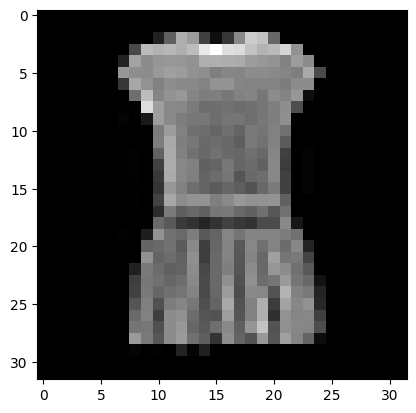

In [4]:
plt.imshow(x_train[3,:,:,0])
plt.gray()
plt.show()

In [ ]:
class GeneratorDistribution(object):
  # source: https://aylien.com/blog/introduction-generative-adversarial-networks-code-tensorflow
  
  def __init__(self, range):
    self.range = range

  def sample(self, N):
    return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

## Generator

In [85]:
def get_generator_model(input_shape=(100,), output_shape=(32,32)):
  """
  return the model of the generator
  parameters:
  output_shape is a tuple containing two values
  """
  x = Input(shape=input_shape)

  u1 = output_shape[0]//16
  h1 = 128
  dense = Dense(u1*u1*h1)(x)
  h1 = h1*4
  dense = Dense(u1*u1*h1)(dense)
  norm = BatchNormalization()(dense)
  layer = LeakyReLU()(norm)
  layer = Reshape((u1, u1, h1))(layer)

  for i in range(4):
    h1 = h1//2
    strides = 1
    for i in range(2):
      layer = Conv2DTranspose(h1, 3, strides, padding='same')(layer)
      layer = BatchNormalization()(layer)
      layer = LeakyReLU()(layer)
      strides = strides * 2

  # for i in range(3):
  #   h1 = h1//2
  #   u2 = u1*2
  #   layer = Conv2DTranspose(h1, 3, 2, padding='same')(layer)

  #   for i in range(2):
  #     layer = Conv2D(h1, 3, 1, padding='same', activation='relu')(layer)

  y = Conv2DTranspose(1,1,1, padding='same', activation='sigmoid')(layer)

  model = Model(x, y)
  print(model.summary())
  return model


In [86]:
generator = get_generator_model()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_13 (Dense)            (None, 512)               51712     
                                                                 
 dense_14 (Dense)            (None, 2048)              1050624   
                                                                 
 batch_normalization_121 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape_3 (Reshape)         (None, 2, 2, 512)         0         
                                                           

(10, 32, 32, 1)


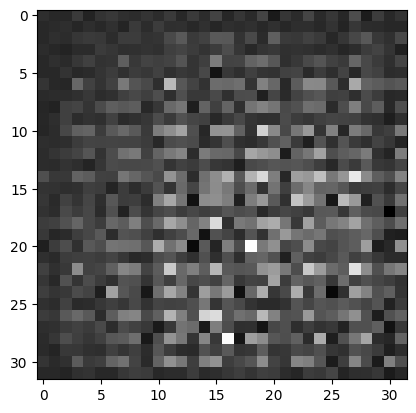

tf.Tensor(
[0.50003445 0.50009626 0.5000688  0.50005203 0.5001103  0.5001222
 0.5000418  0.50016975 0.5000751  0.50016016 0.500352   0.50001633
 0.50025654 0.5001752  0.50015295 0.50018764 0.50036925 0.5001323
 0.50027674 0.50004464 0.5005433  0.50015956 0.5002259  0.5002041
 0.5002976  0.50012773 0.5002388  0.49996048 0.50016886 0.50020117
 0.50025415 0.50001556], shape=(32,), dtype=float32)


In [7]:
# image generated without training
noise = tf.random.normal([10, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()
print(generated_image[0, :, 10, 0])

## Discriminator

In [98]:
def get_discriminator_model(input_shape=(32,32,1)):
  x = Input(shape=(input_shape))
  # layer = Rescaling(1./255)(x)
  # layer = Reshape((1,32,32))(x)
  
  d = input_shape[0]
  h1 = 32
  # layer = Conv2D(h1, 3, padding='same', activation='relu', data_format='channels_first')(layer)
  layer = Conv2D(h1, 3, padding='same')(x)
  layer = LeakyReLU()(layer)
  
  for i in range(4):
    layer = Conv2D(h1, 3, padding='same')(layer)
    layer = LeakyReLU()(layer)
    layer = Conv2D(h1, 3, padding='same')(layer)
    layer = LeakyReLU()(layer)
    
    #layer = Reshape((d,d,h1))(layer)
    layer = MaxPooling2D((2,2))(layer)
    h1 = h1*2
    d = d//2
  
  layer = Dropout(.2)(layer)
  layer = Flatten()(layer)
  layer = Dense(h1//2)(layer)
  layer = LeakyReLU()(layer)
  layer = Dense(h1//8)(layer)
  layer = LeakyReLU()(layer)
  
  y = Dense(1, activation='sigmoid')(layer)

  model = Model(x, y)
  print(model.summary())
  return model

In [99]:
discriminator = get_discriminator_model()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_172 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_173 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_174 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 32, 32, 32)        0  

## Loss function and optimizers

In [10]:
!mkdir training_checkpoints

In [100]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [101]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## Training

In [102]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(f"{len(train_dataset)}")

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


235


In [103]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
noise = None
generated_images = None
real_output = None
fake_output = None
gen_loss = None
disc_loss = None
gradients_of_generator = None
gradients_of_discriminator = None

@tf.function
def train_step(images):
  global noise, generated_image, real_output, fake_output, gen_loss, disc_loss, gradients_of_generator, gradients_of_discriminator

  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  # print(f"images shape: {images.shape}\nnoise shape: {noise.shape}")

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    # print(f"generated images shape: {generated_images.shape}")

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [104]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      # print(f"image batch shape: {image_batch.shape}")
      train_step(image_batch)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f"gen_loss: {gen_loss}   disc_loss: {disc_loss}")

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs,seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [64]:
train(train_dataset, EPOCHS)


Time for epoch 1 is 36.66096520423889 sec
Time for epoch 2 is 24.15246343612671 sec
Time for epoch 3 is 23.783912897109985 sec
Time for epoch 4 is 23.815901517868042 sec
Time for epoch 5 is 24.011834859848022 sec
Time for epoch 6 is 23.90442991256714 sec
Time for epoch 7 is 23.780311584472656 sec
Time for epoch 8 is 23.77782678604126 sec
Time for epoch 9 is 23.821516036987305 sec
Time for epoch 10 is 23.885895013809204 sec
Time for epoch 11 is 23.76420497894287 sec
Time for epoch 12 is 23.763095140457153 sec
Time for epoch 13 is 23.831923484802246 sec
Time for epoch 14 is 23.866856813430786 sec
Time for epoch 15 is 24.357905626296997 sec
Time for epoch 16 is 23.796587467193604 sec
Time for epoch 17 is 23.749140739440918 sec
Time for epoch 18 is 23.765610456466675 sec
Time for epoch 19 is 23.743924379348755 sec
Time for epoch 20 is 23.70754361152649 sec
Time for epoch 21 is 23.775134801864624 sec
Time for epoch 22 is 23.720370292663574 sec
Time for epoch 23 is 23.755584239959717 sec
Tim

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [66]:
print(f"generator loss: {gen_loss}\ndiscriminator loss: {disc_loss}")

generator loss: None
discriminator loss: None


Generated images


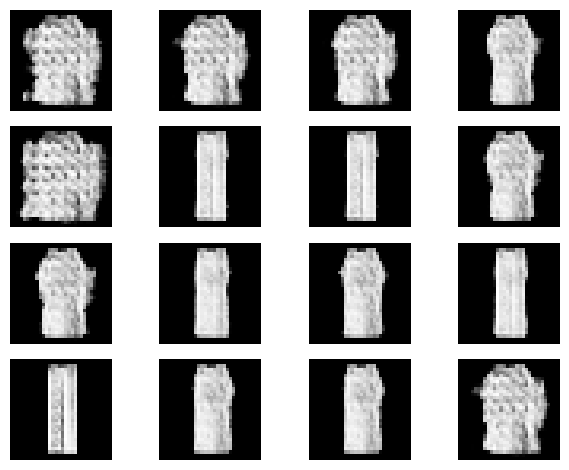

In [74]:
noise = tf.random.normal([16, 100])
generated_image = generator(noise, training=False)
print("Generated images")

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4)

# Loop over the images and axes and plot them
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_image[i])
    ax.axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
# Show the figure
plt.show()


In [76]:
noise = tf.random.normal([10000, 100])
generated_image = generator(noise, training=False)

# Compute the FID between the Test set and 10k generated images
generated_images_fid = get_fid(x_test, generated_image)

# Print out the results
print(f"FID(x_test, x_train) = {generated_images_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
1/1 [==============================] - 9s 9s/step
Processed 100 images.
1/1 [==============================] - 0s 125ms/step
Processed 200 images.
1/1 [==============================] - 0s 126ms/step
Processed 300 images.
1/1 [==============================] - 0s 124ms/step
Processed 400 images.
1/1 [==============================] - 0s 122ms/step
Processed 500 images.
1/1 [==============================] - 0s 117ms/step
Processed 600 images.
1/1 [==============================] - 0s 120ms/step
Processed 700 images.
1/1 [==============================] - 0s 129ms/step
Processed 800 images.
1/1 [==============================] - 0s 144ms/step
Processed 900 images.
1/1 [==============================] - 0s 133ms/step
Processed 1000 images.
1/1 [==============================] - 0s 121ms/step
Processed 1100 images.
1/1 [==============================] - 0s 121ms/step
Processed 1200 images.
1/1 [==============================] - 0s 13

NameError: ignored

In [78]:
print(generated_images_fid)

294.3285556793279
